In [3]:
cd ..

/Users/michitaro/Library/Mobile Documents/com~apple~CloudDocs


In [4]:
import hscdb2

### count all objects

In [6]:
sql = '''
SELECT
    count(*)
FROM
    pdr1_wide
'''
%time hscdb2.dataframe(sql)

CPU times: user 2.47 ms, sys: 1.86 ms, total: 4.33 ms
Wall time: 39.3 ms


,group,select_0
0,None,84017247


### count clean objects

In [7]:
filters = 'grizy'

flags = '''
    centroid_sdss_flags flags_pixel_edge
    flags_pixel_interpolated_center flags_pixel_saturated_center
    flags_pixel_cr_center flags_pixel_bad cmodel_flux_flags
    '''.split()

sql = f'''
SELECT
    count(*)
FROM
    pdr1_wide
WHERE
    ref."detect_is-primary"
    AND { ' AND '.join(f'forced.{f}.id NOTNULL' for f in filters) }
    AND { ' AND '.join(f'NOT forced.{f}.{flag}' for f in filters for flag in flags) }
'''

%time hscdb2.dataframe(sql)

CPU times: user 2.63 ms, sys: 1.6 ms, total: 4.23 ms
Wall time: 252 ms


,group,select_0
0,None,24275978


### count group by

In [8]:
sql = '''
SELECT
    count(*)
FROM
    pdr1_wide
GROUP BY
    ref.is_primary
'''
%time hscdb2.dataframe(sql)

CPU times: user 2.49 ms, sys: 1.73 ms, total: 4.22 ms
Wall time: 280 ms


,group,select_0
0,[False],31359084
1,[True],52658163


### histogram

In [9]:
hist1 = hscdb2.dataframe('''
SELECT
    histogram(f2m(forced.i.flux_sinc), bins => 200), count(*)
FROM
    pdr1_udeep
GROUP BY
    ref."detect_is-primary"
''')
hist1

,group,select_0,select_1
0,[False],"[[10, 14, 7, 30, 44, 54, 82, 93, 103, 155, 226...",1848072
1,[True],"[[1, 1, 2, 4, 17, 26, 45, 59, 101, 162, 288, 5...",3225285


<IPython.core.display.Javascript object>


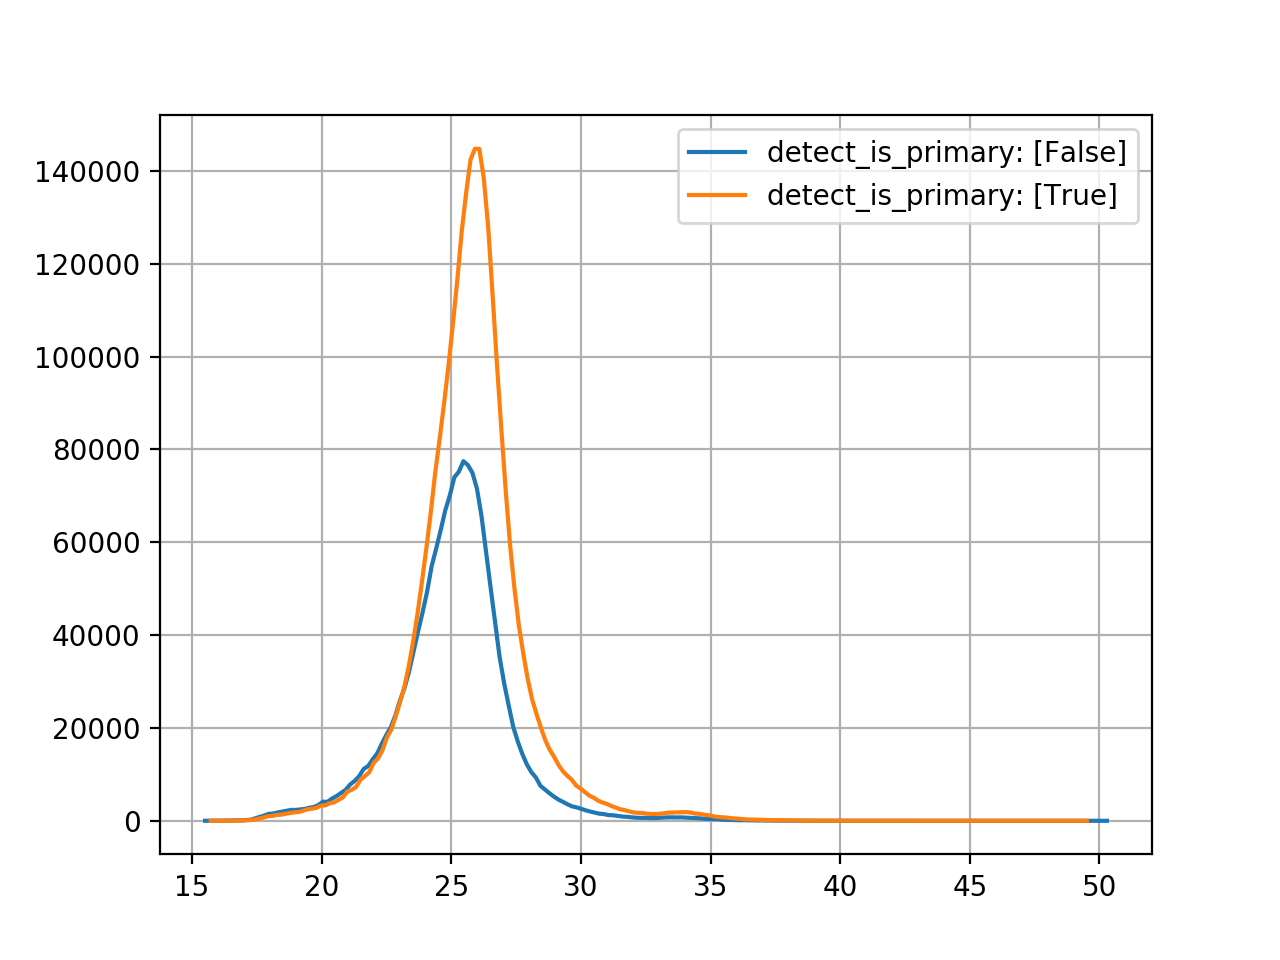

In [10]:
%matplotlib notebook
from matplotlib import pyplot

for i, row in hist1.iterrows():
    hist, bins = row['select_0']
    group = row['group']
    pyplot.plot(bins[1:], hist, label=f'detect_is_primary: {group}')
pyplot.grid()
pyplot.legend()

### 2d histogram

CPU times: user 15.5 ms, sys: 10.5 ms, total: 26 ms
Wall time: 1.06 s
     group                                           select_0
0  [False]  [[[56.0, 31.0, 44.0, 43.0, 59.0, 56.0, 33.0, 4...
1   [True]  [[[205.0, 210.0, 234.0, 222.0, 224.0, 231.0, 2...


<IPython.core.display.Javascript object>


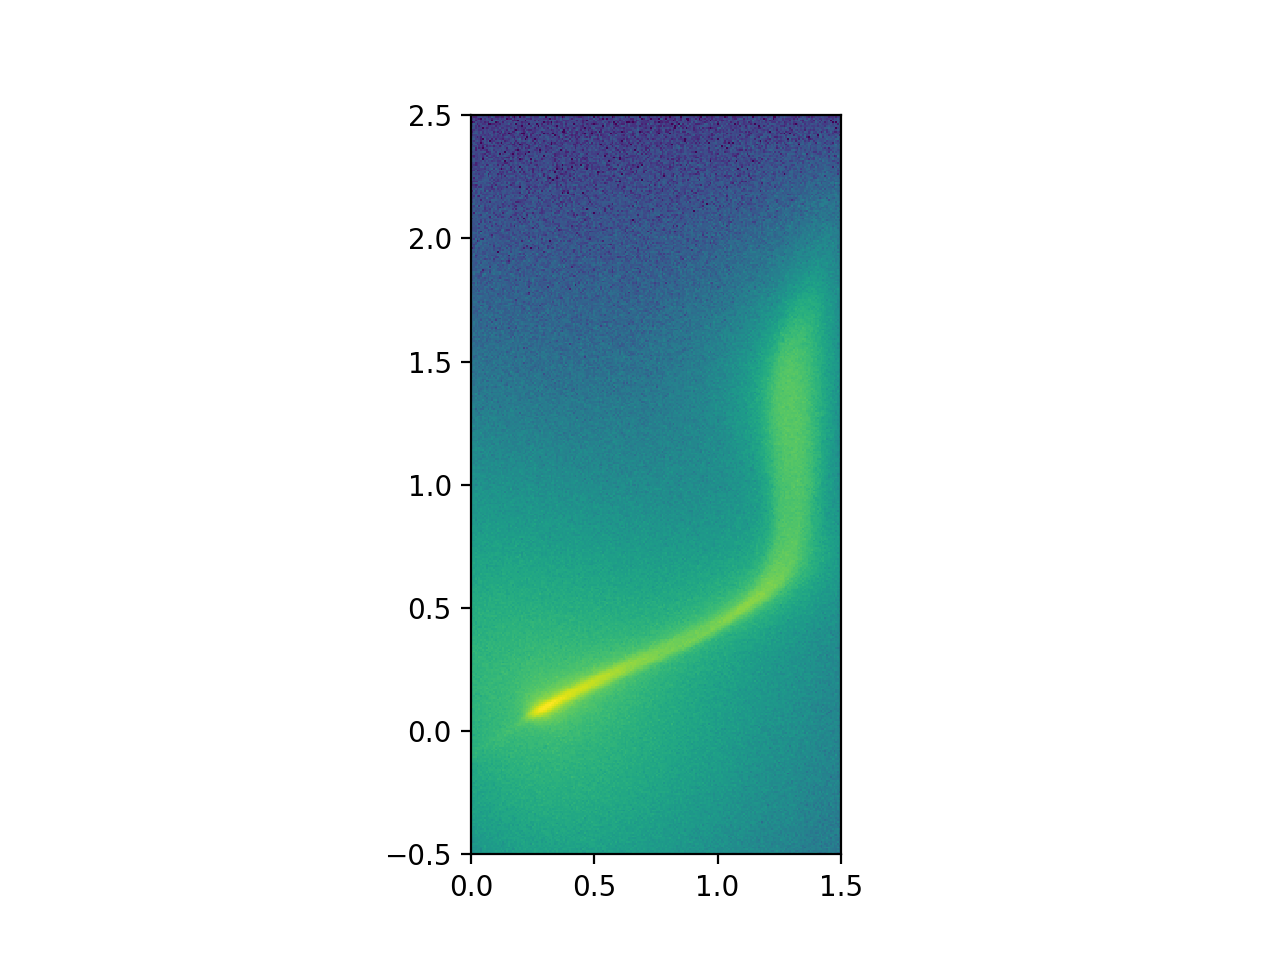

In [11]:
sql = f'''
SELECT
    histogram2d(
        f2m(forced.g.flux_sinc) - f2m(forced.r.flux_sinc),    
        f2m(forced.r.flux_sinc) - f2m(forced.i.flux_sinc),
        bins => (200, 400),
        range => ((0, 1.5), (-0.5, 2.5))
    )    
FROM
    pdr1_wide
GROUP BY
    ref.classification_extendedness > 0.5
'''

%time stellarsequence = hscdb2.dataframe(sql)
print(stellarsequence)

import numpy

hist, xedges, yedges = stellarsequence['select_0'][0]
%matplotlib notebook
pyplot.imshow(numpy.log(1 + hist.T), origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])